In [51]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [52]:
historical = pd.read_csv('calls-2024-01-19.csv').set_index("Date").sort_index()

last_date  = pd.to_datetime(historical.index[-1])
next_date = last_date + pd.Timedelta(days=1)
next_date = next_date.strftime('%Y-%m-%d')

spx = yf.download("^SPX", start=historical.index[0], end=next_date)['Close']
irx = yf.download("^IRX", start=historical.index[0], end=next_date)['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [66]:
from scipy.optimize import minimize
from scipy.stats import norm

# Define the Hurst exponent function (sinusoidal)
def h(t, A, B, C, D):
    return A * np.cos(B * t + C) + D

# Multifractional Black-Scholes Call price formula
def mBS_call_price(S0, K, T, t, r, sigma, H_params):    
    A, B, C, D = H_params
    T = T - t
    H_T = h(T, A, B, C, D)
    variance = sigma**2 * T**(2 * H_T)
    d1 = (np.log(S0 / K) + r * T + 0.5 * variance) / np.sqrt(variance)
    d2 = d1 - np.sqrt(variance)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Objective function to minimize (sum of squared errors)
def calibrate_mBS_full(params):
    A, B, C, D, sigma = params    

    H = (A, B, C, D)

    temp_df = historical.copy()

    total = []
    for rows in temp_df.iterrows():
        date_index = rows[0]
        s = float(spx.loc[date_index].item())
        r = float(irx.loc[date_index].item())*0.01
        t = (pd.to_datetime(maturity_date) - pd.to_datetime(date_index)).days / 365

        for i, v in rows[1].to_dict().items():
            if not np.isnan(v):
                c = mBS_call_price(s, float(i), t, 0, r, sigma, H)
                total.append((c - v)**2)
    mse = sum(total)/len(total)
    return mse

maturity_date = '2024-01-19'

# Bounds for parameters
initial_guess = [1, 2*np.pi*252/30, 0.0, 0.5, 0.2]

bounds = [(0.01, 1), (0.01, np.inf), (0, 2 * np.pi), (0, 0.5), (0.01, 10)]

result = minimize(calibrate_mBS_full, initial_guess, bounds=bounds)
A, B, C, D, sigma = result.x

print(A, B, C, D, sigma)

0.01 25.25842291312071 0.28643715694060773 0.5 0.1390616447285243


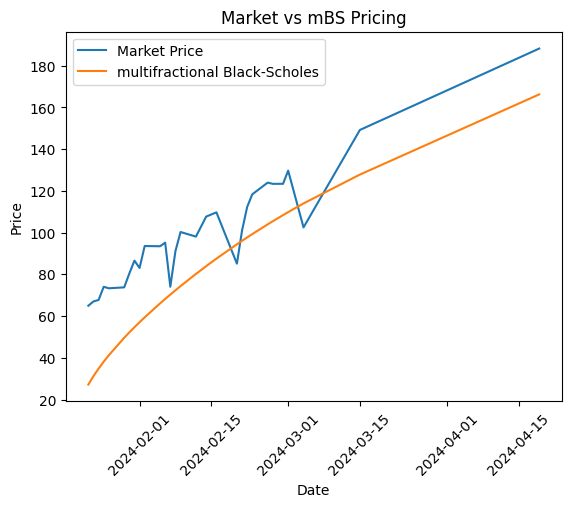

In [67]:
import pandas as pd

future_options = pd.read_csv('weekly_contracts_100.csv')

K = 4775.0

temp_df = future_options[future_options.Strike == K]\
    [['Maturity', 'Close']]
temp_df['Maturity'] = pd.to_datetime(temp_df['Maturity'])

temp_df = temp_df[temp_df['Maturity'] < '2024-05-01']

temp_df.sort_values(by='Maturity', inplace=True)

s0 = spx.iloc[-1].item()
r = irx.iloc[-1].item()*0.01

T = lambda x: (x - pd.to_datetime(maturity_date)).days / 365

temp_df['mBS']  = temp_df["Maturity"].apply(
    lambda x: mBS_call_price(s0, K, T(x), 0, r, sigma, (A, B, C, D))
    )

plt.plot(temp_df['Maturity'], temp_df['Close'], label='Market Price')
plt.plot(temp_df['Maturity'], temp_df['mBS'], label='Black-Scholes Price')
plt.tick_params(axis='x', rotation=45)

plt.legend(['Market Price', 'multifractional Black-Scholes'])
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Market vs mBS Pricing")

plt.show()

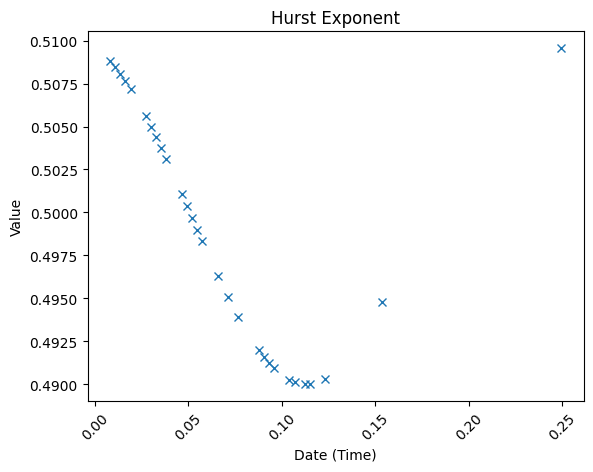

In [74]:
plt.plot(
        temp_df['Maturity'].apply(lambda x: T(x)), 
        temp_df["Maturity"].apply(lambda x:h(T(x), A, B, C, D)),
    'x'
    )
plt.xlabel("Date (Time)")
plt.ylabel("Value")
plt.title("Hurst Exponent")
plt.tick_params(axis='x', rotation=45)

In [69]:
print("Least Squares Error: ", ((temp_df['mBS'] - temp_df['Close'])**2).mean())

Least Squares Error:  597.7409477883907


In [70]:
spx_on_maturity = yf.download("^SPX", start='2024-01-01', end='2024-12-31')['Close']
spx_on_maturity = spx_on_maturity[spx_on_maturity.index.isin(temp_df['Maturity'])]


temp_df['SPX'] = temp_df['Maturity'].map(spx_on_maturity.to_dict()['^SPX'])

temp_df['Payoff'] = temp_df['SPX'] - K
temp_df["Payoff Ratio"] = temp_df["Payoff"] / temp_df["Close"]

temp_df

[*********************100%***********************]  1 of 1 completed


,Maturity,Close,mBS,SPX,Payoff,Payoff Ratio
13,2024-01-22,65.00,27.241304,4850.430176,75.430176,1.160464
31,2024-01-23,67.05,31.255272,4864.600098,89.600098,1.336318
53,2024-01-24,67.74,34.859353,4868.549805,93.549805,1.381013
75,2024-01-25,74.07,38.173233,4894.160156,119.160156,1.608751
99,2024-01-26,73.35,41.268279,4890.970215,115.970215,1.581053
125,2024-01-29,73.80,49.639844,4927.930176,152.930176,2.072225
148,2024-01-30,80.41,52.206859,4924.970215,149.970215,1.865069
175,2024-01-31,86.60,54.688297,4845.649902,70.649902,0.815819
204,2024-02-01,83.10,57.094766,4906.189941,131.189941,1.578700
226,2024-02-02,93.60,59.434734,4958.609863,183.609863,1.961644


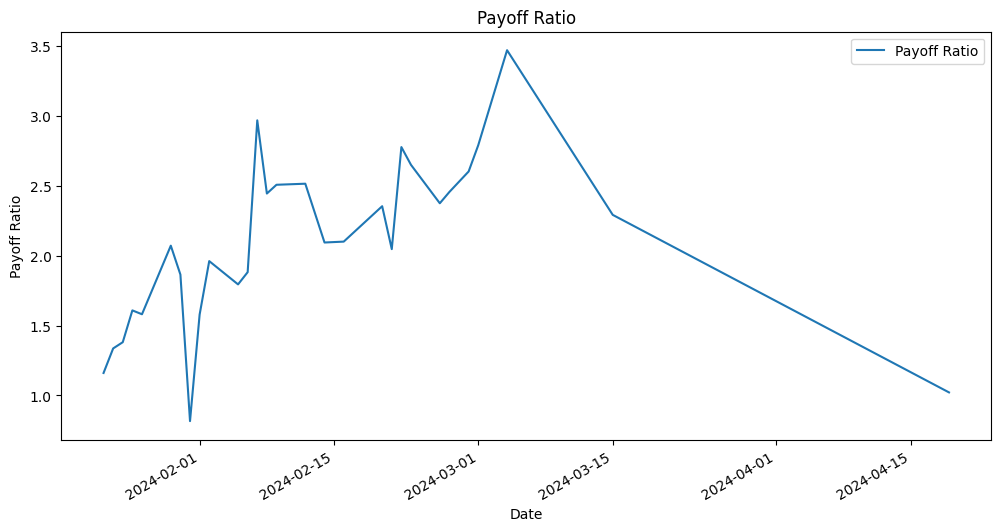

In [71]:
temp_df.plot(x='Maturity', y=['Payoff Ratio'], figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Payoff Ratio")
plt.title("Payoff Ratio")

plt.show()

In [72]:
np.corrcoef(np.abs(temp_df['Close']-temp_df['mBS']), temp_df['Payoff Ratio'])

array([[ 1.        , -0.72650416],
       [-0.72650416,  1.        ]])

In [75]:
from scipy.stats import norm
import numpy as np

def heston_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0):
    """
    Heston model call option price.
    
    Parameters:
    S0 : float : initial stock price
    K : float : strike price
    T : float : time to maturity
    r : float : risk-free rate
    kappa : float : rate of mean reversion of variance
    theta : float : long-term variance
    sigma : float : volatility of variance
    rho : float : correlation between the two Brownian motions
    v0 : float : initial variance
    
    Returns:
    float : call option price
    """
    def char_func(u):
        i = complex(0, 1)
        d = np.sqrt((rho * sigma * u * i - kappa)**2 + (u**2 + u * i) * sigma**2)
        g = (kappa - rho * sigma * u * i - d) / (kappa - rho * sigma * u * i + d)
        C = r * u * i * T + (kappa * theta / sigma**2) * ((kappa - rho * sigma * u * i - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
        D = ((kappa - rho * sigma * u * i - d) / sigma**2) * ((1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))
        return np.exp(C + D * v0 + i * u * np.log(S0))
    
    def integrand(u):
        i = complex(0, 1)
        return (np.exp(-i * u * np.log(K)) * char_func(u - i)) / (i * u * char_func(-i))
    
    integral = np.real(np.trapz([integrand(u) for u in np.linspace(0, 100, 1000)], dx=0.01))
    return S0 - np.exp(-r * T) * K * integral

# Example usage
S0 = 100  # initial stock price
K = 100   # strike price
T = 1     # time to maturity
r = 0.05  # risk-free rate
kappa = 2.0  # rate of mean reversion of variance
theta = 0.02  # long-term variance
sigma = 0.1  # volatility of variance
rho = -0.7  # correlation between the two Brownian motions
v0 = 0.02  # initial variance

call_price = heston_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0)
print(f"Heston model call option price: {call_price}")

Heston model call option price: nan


C:\Users\santo\AppData\Local\Temp\ipykernel_37748\356738360.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.exp(-i * u * np.log(K)) * char_func(u - i)) / (i * u * char_func(-i))
C:\Users\santo\AppData\Local\Temp\ipykernel_37748\356738360.py:32: RuntimeWarning: invalid value encountered in scalar divide
  return (np.exp(-i * u * np.log(K)) * char_func(u - i)) / (i * u * char_func(-i))
c:\Users\santo\Desktop\option-pricing\.venv\lib\site-packages\numpy\lib\function_base.py:4979: RuntimeWarning: invalid value encountered in multiply
  ret = (d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0).sum(axis)
